# import modules

In [135]:
#import
from __future__ import division
from path import Path
from scipy.signal import find_peaks
from collections import Counter
from IPython.display import Markdown as md

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import scipy as scipy
import pandas as pd
import pathlib
import h5py
import seaborn as sns
import matplotlib.gridspec as gridspec
import zarr
import scipy.stats as stats

from fklab.io import neuralynx as nlx
from fklab.signals.core.basic_algorithms import event_triggered_average
from fklab.signals.filter import compute_envelope, apply_filter
from fklab.signals.multirate import decimate

%matplotlib inline
%matplotlib notebook

In [136]:
def downsample_csc_file(path, fs, epoch):
    """Helper function to downsample csc file,
    
    Parameters
    ----------
    path : path
        location of csc file
    fs : int
        desired sampling frequency
    epoch : [start, stop]
        time window
    
    Returns
    -------
    time: 1d array
        time vector
    signal: 1d array
        signal vector
    
    """
    
    fid = nlx.NlxOpen(path, clip=False)
    fs_orig = fid.header['SamplingFrequency']
    
    if fs_orig < fs:
        # should we upsample? or raise an exception? or continue?
        raise ValueError("Original sampling frequency is lower than desired sampling frequency.")
    elif (fs_orig % fs)>0:
        raise ValueError("Cannot perform downsampling. Original sampling frequency is not a multiple of the desired sampling frequency.")
    
    downsample_factor = int(fs_orig // fs)
    
    # load data
    data = fid.readdata(epoch[0], epoch[1])
    
    if downsample_factor>1:
        time = data.time[::downsample_factor]
        signal = decimate(data.signal, downsample_factor, axis=0, zero_phase=True)
    else:
        time = data.time
        signal = data.signal
    
    return time, signal

In [133]:
def ripple_envelope(signals, **kwargs):

    smooth_options = dict(kernel="gaussian", bandwidth=0.0075)
    smooth_options.update(kwargs.pop("smooth_options", {}))

    filter_options = dict(transition_width="25%", attenuation=60)
    filter_options.update(kwargs.pop("filter_options", {}))

    return compute_envelope(
        signals,
        "ripple",
        filter_options=filter_options,
        smooth_options=smooth_options,
        **kwargs
    )

# 1. Load Ephys signal

In [3]:
#path = Path("path to acquired Neuralynx folder")
path = Path("/home/chaeyoungkim/Desktop/Miniscope data/manuscript figures/1_manuscript_data/figure7_disruption/MD15/2020-06-26_13-18-40")
 
sampling_rate = 32000
downsample_rate = 4000
 
os.chdir(path)
scriptdirectory = os.getcwd()    
print(scriptdirectory)

#ncs file
file_list = glob.glob('./*.ncs') #Get folder path containing .cluster files    
print(len(file_list))
print(file_list)

/home/chaeyoungkim/Desktop/Miniscope data/manuscript figures/1_manuscript_data/figure7_disruption/MD15/2020-06-26_13-18-40
32
['./CSC9.ncs', './CSC1.ncs', './CSC31.ncs', './CSC16.ncs', './CSC23.ncs', './CSC4.ncs', './CSC26.ncs', './CSC12.ncs', './CSC28.ncs', './CSC3.ncs', './CSC21.ncs', './CSC17.ncs', './CSC5.ncs', './CSC8.ncs', './CSC27.ncs', './CSC18.ncs', './CSC13.ncs', './CSC6.ncs', './CSC10.ncs', './CSC2.ncs', './CSC19.ncs', './CSC11.ncs', './CSC15.ncs', './CSC25.ncs', './CSC32.ncs', './CSC7.ncs', './CSC30.ncs', './CSC14.ncs', './CSC22.ncs', './CSC29.ncs', './CSC24.ncs', './CSC20.ncs']


In [4]:
#specify channel numbers used for recording
recording_channels=[9, 10, 11, 12] #recording channels from your EIB board
valid_channels=['./CSC9.ncs', './CSC10.ncs', './CSC11.ncs', './CSC12.ncs']

In [5]:
valid_file_list=[]

for f, file in enumerate(valid_channels): 
    FP = nlx.NlxOpen(file)
    data = FP.readdata()
    if len(data.signal)!=0:
        print(str(f)+file)
        new_file_name=file.replace('./', '')
        valid_file_list.append(new_file_name)
 
print(valid_file_list)

0./CSC9.ncs
1./CSC10.ncs
2./CSC11.ncs
3./CSC12.ncs
['CSC9.ncs', 'CSC10.ncs', 'CSC11.ncs', 'CSC12.ncs']


In [6]:
#load Neuralynx events: ripple detection
"""Set .env files folder """

nev_file_list = glob.glob('./*.nev')
detect_string = 'ripple_detection' #'TTL Input on AcqSystem1_0 board 0 port 0 value (0x0000).','stim','miniscope' 
time_window=np.array([0,10000000000.])

#get events data
event_file = nlx.NlxOpen(nev_file_list[0])

ripple_detection = event_file.readdata(start=time_window[0],stop=time_window[1]).time[
               event_file.readdata(start=time_window[0],stop=time_window[1]).eventstring == detect_string.encode()]

In [7]:
#get time from nev file
time = event_file.data[0:-1][0]
 
#get event from nev file
event = event_file.data[0:-1][1]
print(event[0:10])
 
#make time-event_table
time_event_table = pd.DataFrame({'time': time, 'event': event})

#get detection and stim time in nev files
online_ripple = time_event_table['event']==b'ripple_detection'
stim          = time_event_table['event']==b'stim'
miniscope     = time_event_table['event']==b'miniscope'

online_ripple_df    = time_event_table[online_ripple]
stim_df             = time_event_table[stim]
miniscope_df        = time_event_table[miniscope]

[b'Starting Recording' b'synchronize'
 b'TTL Input on AcqSystem1_0 board 0 port 1 value (0x0000).'
 b'synchronize'
 b'TTL Input on AcqSystem1_0 board 0 port 1 value (0x0000).'
 b'synchronize' b'ripple_detection' b'stim'
 b'TTL Input on AcqSystem1_0 board 0 port 0 value (0x0000).' b'stim']


In [46]:
#Slice online SWR-stimulation events

online_spon=online_ripple_df['time'][61:419] #sliced by the correspoinding time window
online_stim=online_ripple_df['time'][472:564]

## 1-2. Downsample csc file/ create time-signal table

In [10]:
downsampled = {}

for i in valid_file_list:
    print(i)
    j=i.replace('CSC', '')
    j=j.replace('.ncs', '')
    j=int(j)

    downsampling = downsample_csc_file(path+'/'+i, downsample_rate, time_window) 

    downsampled_time=downsampling[0]
    downsampled_signal=downsampling[1]
    downsampled[j] = pd.DataFrame({'time': downsampled_time, 'signal': downsampled_signal})
    
    #print(np.isnan(downsampled[j]['signal']).any())


CSC9.ncs
CSC10.ncs
CSC11.ncs
CSC12.ncs


## 1-3. Plot events
### 1) Plot online ripple detection

868


<IPython.core.display.Javascript object>


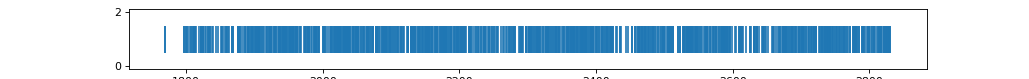

In [13]:
#plot detection time

online_ripple = online_ripple_df['time']
online_ripple = pd.Series.to_numpy(online_ripple)
print(len(online_ripple))

plt.figure(figsize=(13, 1))
plt.eventplot(online_ripple) 


### 2) Plot stim

868


<IPython.core.display.Javascript object>


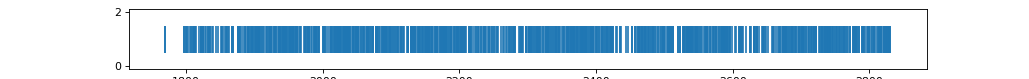

In [14]:
#plot electrical stimuation events

stim_start = stim_df['time'][::2]
stim_start = np.array(stim_start)
print(len(stim_start))


plt.figure(figsize=(13, 1))
plt.eventplot(stim_start)

### 3) Plot miniscope 

12591


<IPython.core.display.Javascript object>


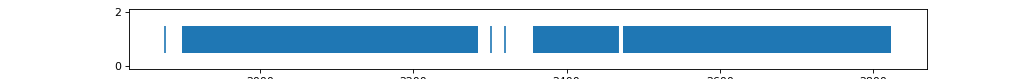

In [15]:
#plot miniscope input

miniscope = miniscope_df['time']
miniscope = np.array(miniscope)
print(len(miniscope))

plt.figure(figsize=(13, 1))
plt.eventplot(miniscope) 

<IPython.core.display.Javascript object>


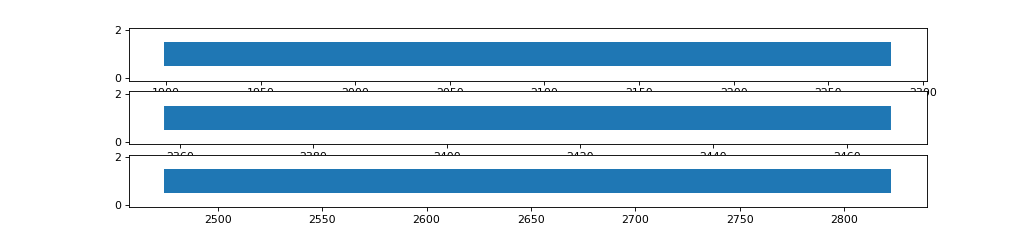

In [17]:
#slice frames by time

spon_miniscope = (miniscope_df[(miniscope_df['time']<2290) &(miniscope_df['time']>1890)])
spon_miniscope = spon_miniscope['time']
spon_miniscope = list(spon_miniscope)


stim_miniscope_1 = (miniscope_df[(miniscope_df['time']<2470) & (miniscope_df['time']>2350)])
stim_miniscope_1 = stim_miniscope_1['time']
stim_miniscope_1 = list(stim_miniscope_1)


stim_miniscope_2 = (miniscope_df[miniscope_df['time']>2470])
stim_miniscope_2 = stim_miniscope_2['time']
stim_miniscope_2 = list(stim_miniscope_2)


fig, ax = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(13,3))
ax[0].eventplot(spon_miniscope)  
ax[1].eventplot(stim_miniscope_1)
ax[2].eventplot(stim_miniscope_2)

### 4) Plot time window to be analyzed

5746
1632
7378


<IPython.core.display.Javascript object>


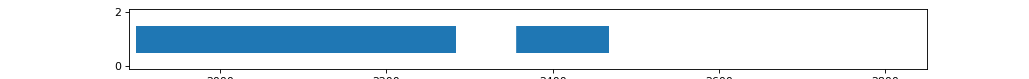

(1890.0, 2850.0)

In [18]:
print((len(spon_miniscope)))
print((len(stim_miniscope_1)))
print(len(spon_miniscope)+len(stim_miniscope_1))

full_time_window = spon_miniscope + stim_miniscope_1

plt.figure(figsize=(13,1))
plt.eventplot(full_time_window)
plt.xlim(1890, 2850)

## 1-4. Define full frames to be analyzed

In [19]:
#spontaneous
#compute frame frequency
FRAME_FREQUENCY_spon= 1/((spon_miniscope[-1] - spon_miniscope[0])/(len(spon_miniscope)-1)/2)

#SWR disruption
#compute frame frequency
FRAME_FREQUENCY_stim= 1/((stim_miniscope_1[-1] - stim_miniscope_1[0])/(len(stim_miniscope_1)-1)/2)
 


#spontaneous
spon_miniscope_full_frames=[]
spon_miniscope_full_frames = spon_miniscope.copy()
for i in range(len(spon_miniscope)-1):
    a=np.mean([spon_miniscope[i],spon_miniscope[i+1]])
    spon_miniscope_full_frames.append(a)
spon_miniscope_full_frames.sort()
spon_miniscope_full_frames.append(spon_miniscope_full_frames[-1]+FRAME_FREQUENCY_spon/1000)
spon_miniscope_full_frames.append(spon_miniscope_full_frames[0]-FRAME_FREQUENCY_spon/1000)
spon_miniscope_full_frames.append(spon_miniscope_full_frames[0]-2*FRAME_FREQUENCY_spon/1000)
spon_miniscope_full_frames.sort()
print(len(spon_miniscope_full_frames))

#swr-disruption
stim_miniscope_full_frames_1 = stim_miniscope_1.copy()
for i in range(len(stim_miniscope_1)-1):
    a=np.mean([stim_miniscope_1[i],stim_miniscope_1[i+1]])
    stim_miniscope_full_frames_1.append(a)
stim_miniscope_full_frames_1.sort()
stim_miniscope_full_frames_1.append(stim_miniscope_full_frames_1[-1]+FRAME_FREQUENCY_stim/1000)
stim_miniscope_full_frames_1.append(stim_miniscope_full_frames_1[0]-FRAME_FREQUENCY_stim/1000)
stim_miniscope_full_frames_1.sort()
print(len(stim_miniscope_full_frames_1))
 
    
full_time_window_all_frames = spon_miniscope_full_frames+stim_miniscope_full_frames_1
full_time_window_all_frames.sort()
print(len(full_time_window_all_frames))

11494
3265
14759


<IPython.core.display.Javascript object>


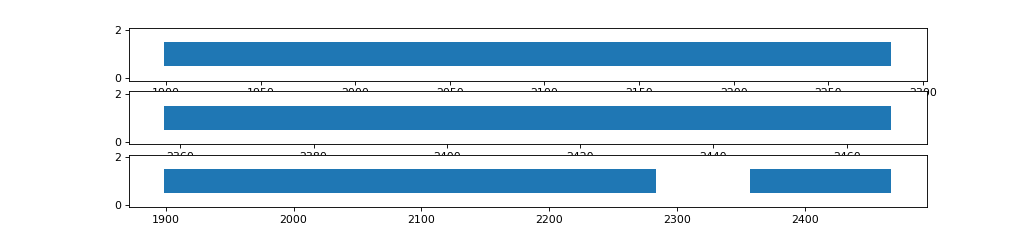

In [20]:
fig, ax = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(13,3))
ax[0].eventplot(spon_miniscope_full_frames) 
ax[1].eventplot(stim_miniscope_full_frames_1)
ax[2].eventplot(full_time_window_all_frames)

# 2. Load ephys data

## 2-1. Filter signal

In [21]:
#channel 9 : MUA filter
csc_9_fp_filtered = apply_filter(downsampled[9]['signal'], [300, 2000], fs=sampling_rate)


#channel 10 : Wideband
csc_10_fp_filtered = apply_filter(downsampled[10]['signal'], [1, 6000], fs=sampling_rate) 
 

#channel 11 : SWR filter
csc_11_fp_filtered = apply_filter(downsampled[11]['signal'], [140,225], fs=downsample_rate)
 

#channel 12 : Wideband
csc_12_fp_filtered = apply_filter(downsampled[12]['signal'], [1, 6000], fs=sampling_rate) 


## 2-2. Plot

<IPython.core.display.Javascript object>


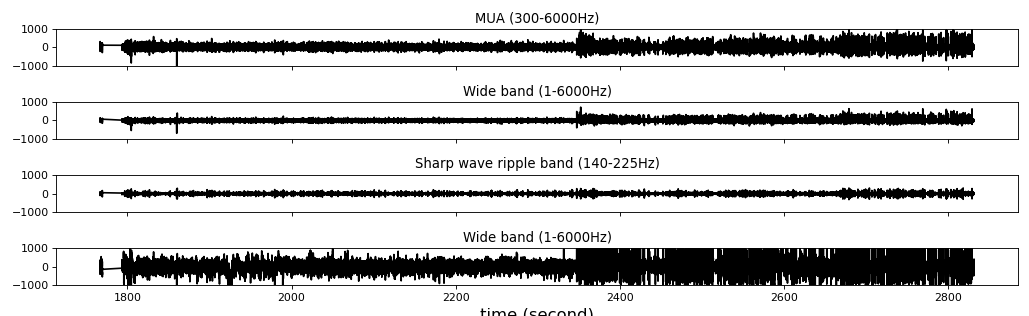

Text(0.5, 14.999999999999972, 'time (second)')

In [23]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(13,4))
 
#MUA
ax[0].set_ylim(-1000, 1000)
ax[0].plot(downsampled[9]['time'], csc_9_fp_filtered, 'k')
ax[0].title.set_text('MUA (300-6000Hz)')

#Wide band
ax[1].set_ylim(-1000, 1000)
ax[1].plot(downsampled[10]['time'], csc_10_fp_filtered , 'k')
ax[1].title.set_text('Wide band (1-6000Hz)')
 
#ripple band
ax[2].set_ylim(-1000, 1000)
ax[2].plot(downsampled[11]['time'], csc_11_fp_filtered , 'k')
ax[2].title.set_text('Sharp wave ripple band (140-225Hz)')

#wide band
ax[3].set_ylim(-1000, 1000)
ax[3].plot(downsampled[12]['time'], csc_12_fp_filtered , 'k')
ax[3].title.set_text('Wide band (1-6000Hz)')

plt.tight_layout()
plt.xlabel('time (second)', fontsize=15)


<IPython.core.display.Javascript object>


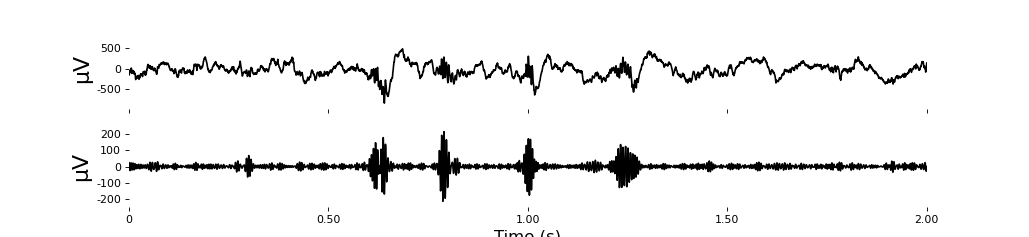

Text(0.5, 0, 'Time (s)')

In [29]:
#spontaneous SWR signal example 

x_ticks_labels=['0','0.25','0.50','0.75','1.00','1.25','1.50','1.75','2.00']
x_ticks_labels_2=['0','0.50', '1.00','1.50','2.00']
y_ticks_labels_1=[ '500','0','-500']
y_ticks_labels_2=['200','100','0','-100','-200']

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(13,3))
ax[0].set_xlim(1896.50, 1898.50)

#wide band
ax[0].set_ylim(-990,990)
ax[0].plot(downsampled[12]['time'], csc_12_fp_filtered, 'k') 
ax[0].set_ylabel('µV', fontsize=20)
ax[0].set_yticks([500, 0, -500])
ax[0].set_yticklabels(y_ticks_labels_1, rotation='horizontal', fontsize=10)
ax[0].set_xticks([])
ax[0].spines['top'].set_visible(False) 
ax[0].spines['bottom'].set_visible(False) 
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

#ripple band
ax[1].set_ylim(-250,250)
ax[1].plot(downsampled[11]['time'], csc_11_fp_filtered, 'k')
ax[1].set_ylabel('µV', fontsize=20)
ax[1].set_xticks([])
ax[1].set_xticks([x for x in np.linspace(1896.50,1898.50,5)])
ax[1].set_xticklabels(x_ticks_labels_2, rotation='horizontal', fontsize=10)
ax[1].set_yticks([200, 100,0,-100,-200])
ax[1].set_yticklabels(y_ticks_labels_2, rotation='horizontal', fontsize=10)
ax[1].spines['top'].set_visible(False) 
ax[1].spines['bottom'].set_visible(False) 
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
    
plt.xlabel('Time (s)', fontsize=15)

<IPython.core.display.Javascript object>


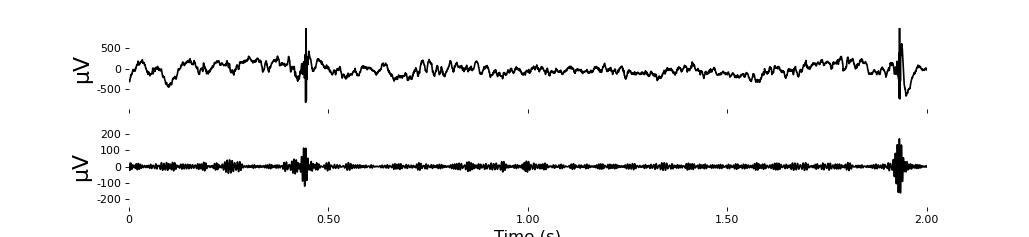

Text(0.5, 0, 'Time (s)')

In [31]:
#disrupted-SWR signal example 

x_ticks_labels=['0','0.25','0.50','0.75','1.00','1.25','1.50','1.75','2.00']
x_ticks_labels_2=['0','0.50', '1.00','1.50','2.00']
y_ticks_labels_1=[ '500','0','-500']
y_ticks_labels_2=['200','100','0','-100','-200']

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(13,3))
ax[0].set_xlim(2404, 2406) 

#Wideband (1-6000)
ax[0].set_ylim(-990,990)
ax[0].plot(downsampled[12]['time'], csc_12_fp_filtered, 'k')
ax[0].set_ylabel('µV', fontsize=20)
ax[0].set_yticks([500, 0, -500])
ax[0].set_yticklabels(y_ticks_labels_1, rotation='horizontal', fontsize=10)
ax[0].set_xticks([])
ax[0].spines['top'].set_visible(False) 
ax[0].spines['bottom'].set_visible(False) 
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

#ripple band
ax[1].set_ylim(-250,250)
ax[1].plot(downsampled[11]['time'], csc_11_fp_filtered, 'k')
ax[1].set_ylabel('µV', fontsize=20)
ax[1].set_xticks([])
ax[1].set_xticks([x for x in np.linspace(2404,2406,5)])
ax[1].set_xticklabels(x_ticks_labels_2, rotation='horizontal', fontsize=10)
ax[1].set_yticks([200, 100,0,-100,-200])
ax[1].set_yticklabels(y_ticks_labels_2, rotation='horizontal', fontsize=10)
ax[1].spines['top'].set_visible(False) 
ax[1].spines['bottom'].set_visible(False) 
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_xticks([x for x in np.linspace(2404,2406,5)])
    
plt.xlabel('Time (s)', fontsize=15)

# 3. Load Calcium transient data

In [33]:
def open_minian(dpath, fname='minian', backend='netcdf', chunks=None, post_process=None):
    if backend is 'netcdf':
        fname = fname + '.nc'
        if chunks is 'auto':
            chunks = dict([(d, 'auto') for d in ds.dims])
        mpath = pjoin(dpath, fname)
        with xr.open_dataset(mpath) as ds:
            dims = ds.dims
        chunks = dict([(d, 'auto') for d in dims])
        ds = xr.open_dataset(os.path.join(dpath, fname), chunks=chunks)
        if post_process:
            ds = post_process(ds, mpath)
        return ds
    elif backend is 'zarr':
        mpath = pjoin(dpath, fname)
        dslist = [xr.open_zarr(pjoin(mpath, d)) for d in listdir(mpath) if isdir(pjoin(mpath, d))]
        ds = xr.merge(dslist)
        if chunks is 'auto':
            chunks = dict([(d, 'auto') for d in ds.dims])
        if post_process:
            ds = post_process(ds, mpath)
        return ds.chunk(chunks)
    else:
        raise NotImplementedError("backend {} not supported".format(backend))


In [100]:
#minian_path='path to you file'
minian_path='/media/chaeyoungkim/Samsung_T52/Miniscope project/data/Miniscope data/MD15/6_26_2020_recording_4/nostim&stim_all'

param_save_minian = {
    'dpath': minian_path,
    'fname': 'minian',
    'backend': 'zarr',
    'meta_dict': False, 
    'overwrite': True}

minian = open_minian(minian_path,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])

In [101]:
Ca = minian['C'] 
Ca_final = minian['C'].where(minian['unit_labels']>=0, drop=True)

print(Ca['unit_id']) 

<xarray.DataArray 'unit_id' (unit_id: 159)>
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158])
Coordinates:
    animal      <U4 'MD15'
    session     <U21 '6_26_2020_reco

## 3-1. plot example calcium signal

<IPython.core.display.Javascript object>


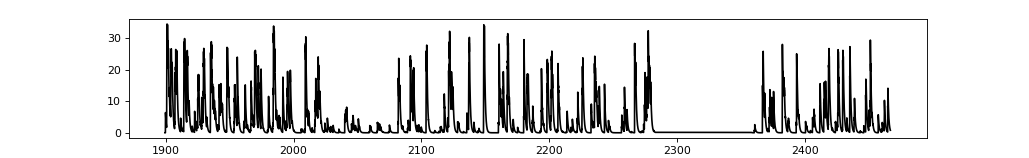

In [102]:
fig, ax = plt.subplots(1,1, sharex=False, sharey=True, figsize=(13,2))
 
x=full_time_window_all_frames
y=Ca_final[0][0:len(full_time_window_all_frames)] 
   
plt.plot(x, y, 'k') 

## 3-2. Correct missing frames 

In [103]:
#spon
path_spon = Path("/home/chaeyoungkim/Desktop/Miniscope data/manuscript figures/1_manuscript_data/figure7_disruption/MD15/6_26_2020_recording_4/H20_M30_S59_nostim")
os.chdir(path_spon)
columns_to_keep = ['camNum', 'frameNum', 'sysClock', 'buffer']
df = pd.read_table("timestamp.dat", sep="\s+", usecols=columns_to_keep)  
sysClock_spon=list(df['sysClock']) #saved time in miniscope software
print(len(sysClock_spon))


#stim
path_disruption = Path("/home/chaeyoungkim/Desktop/Miniscope data/manuscript figures/1_manuscript_data/figure7_disruption/MD15/6_26_2020_recording_4/H20_M38_S37")
#path_disruption = Path("/home/chaeyoungkim/Desktop/Miniscope data/manuscript figures/1_manuscript_data/figure7_disruption/MD15/6_26_2020_recording_4/H20_M40_S34")
os.chdir(path_disruption) 
columns_to_keep = ['camNum', 'frameNum', 'sysClock', 'buffer']
df = pd.read_table("timestamp.dat", sep="\s+", usecols=columns_to_keep)  
sysClock_stim=list(df['sysClock']) #saved time in miniscope software
print(len(sysClock_stim))
 

11455
3255


In [104]:
#dropped frame list is generated from the other uploaded code("Rectify_dropped_miniscope_frames")

spon_dropped_frame_list =[1001, 1002, 1003, 1343, 2130, 2360, 2361, 2697, 2913, 3934, 4048, 4053,
                          4615, 4742, 4844, 4849, 5188, 5299, 5302, 5303, 5308, 6207, 6532, 6533, 
                          6650, 6651, 6767, 7164, 7505, 7843, 7961, 8077, 8194, 8416, 8537, 8760, 
                          8982, 9449, 10574]
stim_dropped_frame_list =[617, 1061, 1402, 1403, 2078, 2083, 2312, 2770, 2991, 3217]

Ca_corrected_frames_spon=[]
Ca_corrected_frames_stim=[]

for i in range(len(Ca_final)):
    #correct spon Calcium
    spon_Ca=Ca_final[i][0:len(sysClock_spon)]
    spon_Ca_series=spon_Ca.to_series()
    spon_Ca_list=spon_Ca_series.tolist()
 
    for j in spon_dropped_frame_list:
         spon_Ca_list.insert(j, np.mean([spon_Ca_list[j-1], spon_Ca_list[j+1]]))
            
    Ca_corrected_frames_spon.append(spon_Ca_list)


    #correct stim Calcium
    stim_Ca=Ca_final[i][len(sysClock_spon):len(sysClock_spon)+len(sysClock_stim)]
    stim_Ca_series=stim_Ca.to_series()
    stim_Ca_list=stim_Ca_series.tolist()
 
    for k in stim_dropped_frame_list:
         stim_Ca_list.insert(k, np.mean([stim_Ca_list[k-1], stim_Ca_list[k+1]]))
               
    Ca_corrected_frames_stim.append(stim_Ca_list)

    
Ca_corrected_frames_spon=np.array(Ca_corrected_frames_spon)
Ca_corrected_frames_stim=np.array(Ca_corrected_frames_stim)


## 3-3. Plot with fixed timestamp

### 1) Spontaneous

<IPython.core.display.Javascript object>


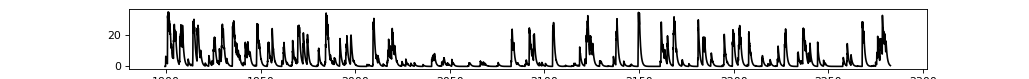

In [105]:
plt.figure(figsize=(13, 1))
 
plt.plot(spon_miniscope_full_frames, Ca_corrected_frames_spon[0],'k') 

### 2) SWR-disruption

<IPython.core.display.Javascript object>


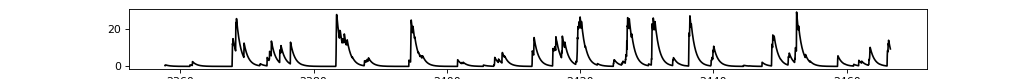

In [106]:
plt.figure(figsize=(13, 1))
 
plt.plot(stim_miniscope_full_frames_1, Ca_corrected_frames_stim[0],'k') 
plt.show()

# 4. Combine ephys & calcium data

## 4-1. Detect calcium peaks & slice SWRs by peaks

<IPython.core.display.Javascript object>


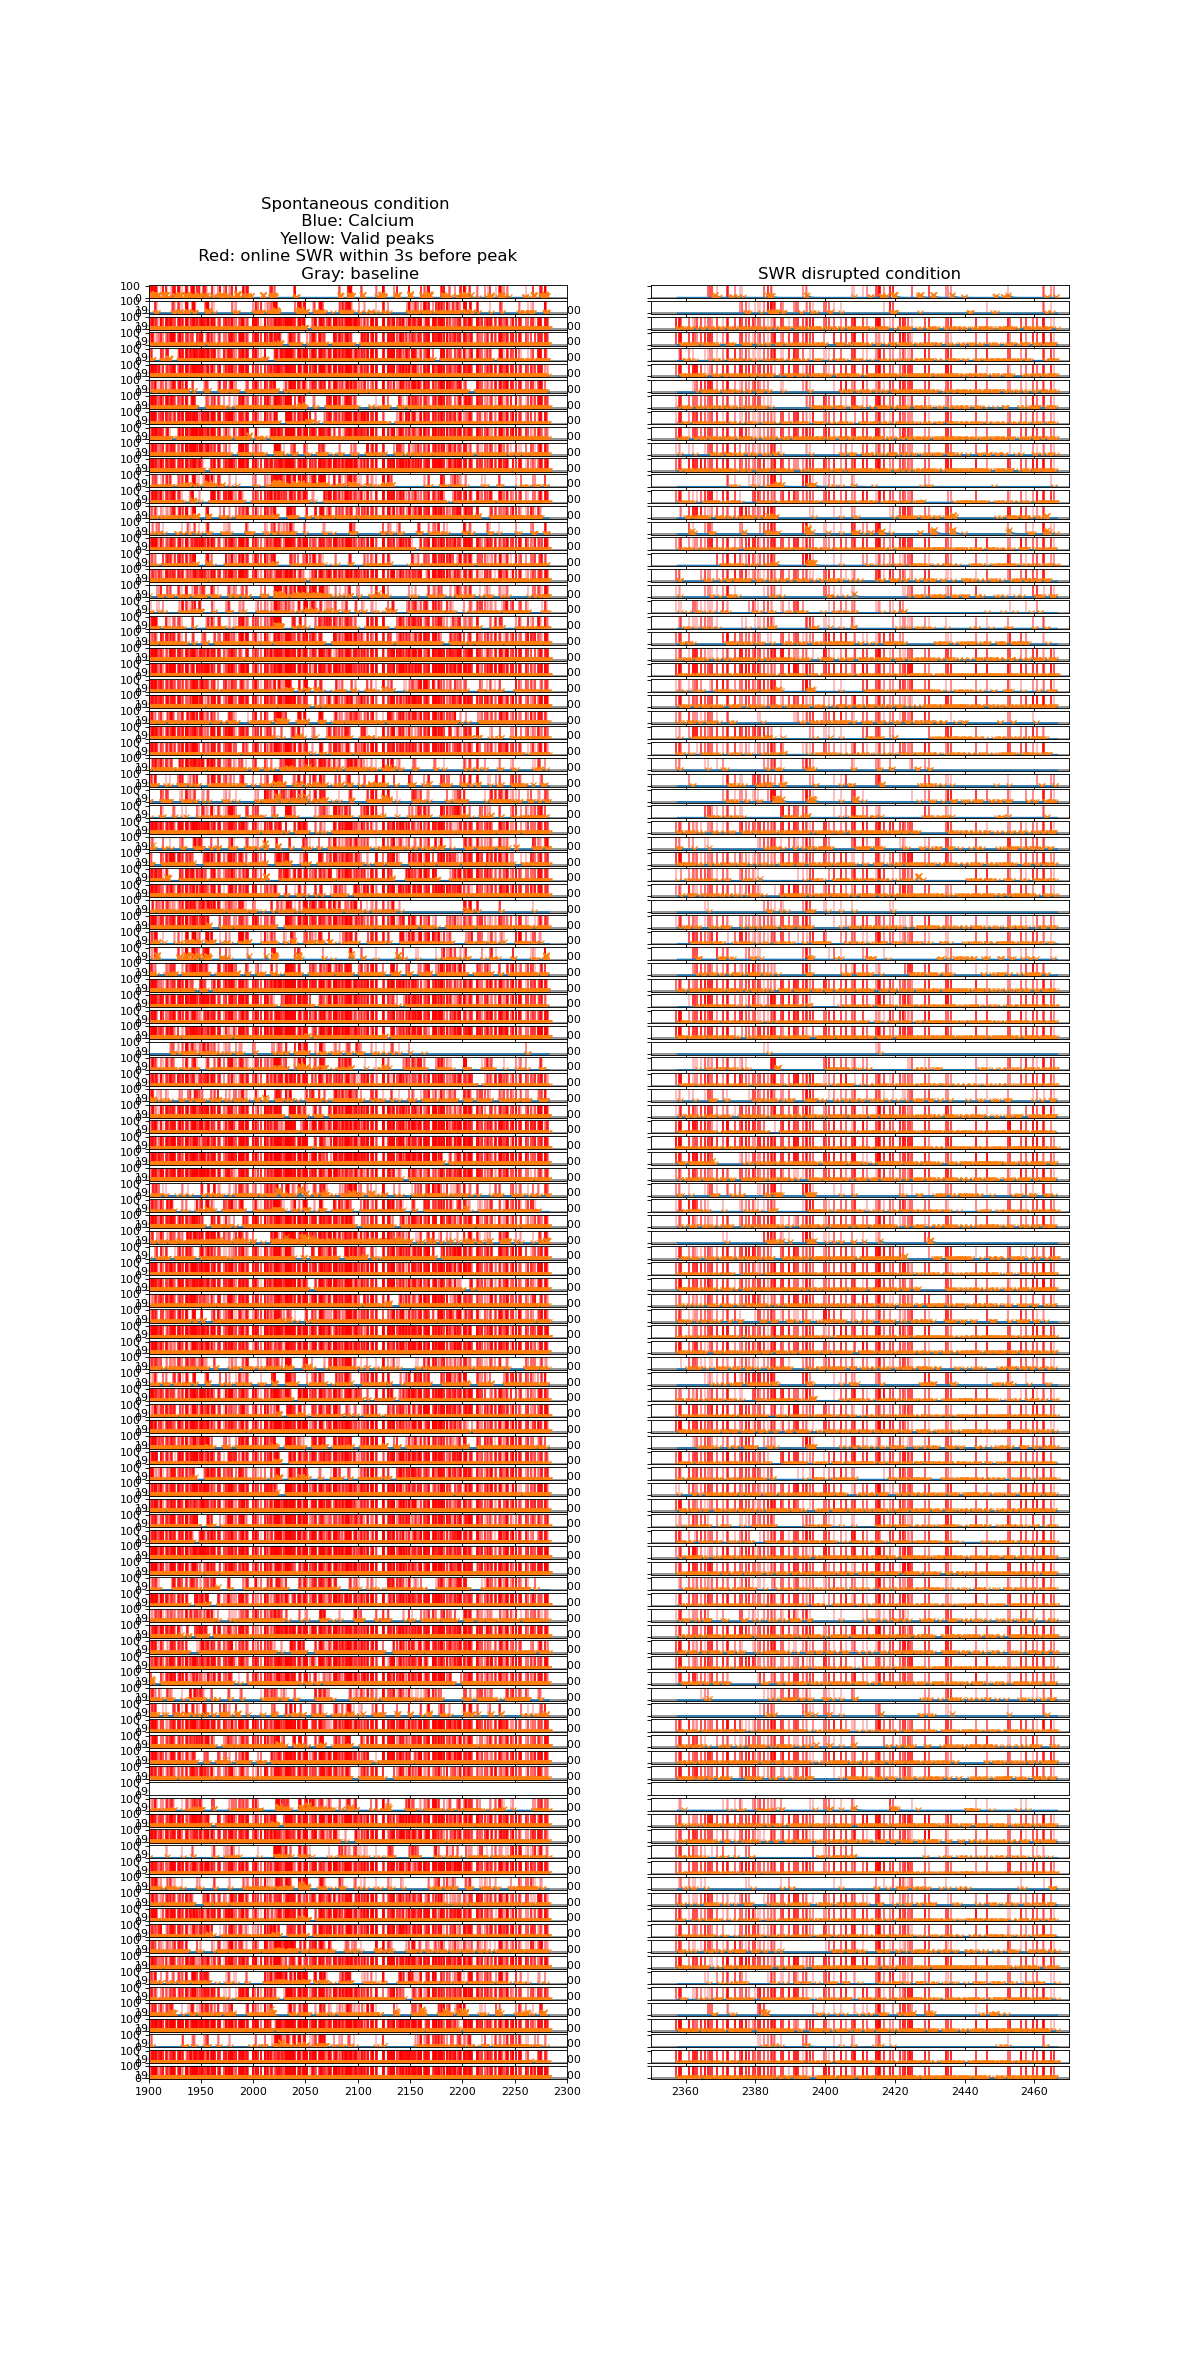

/home/chaeyoungkim/miniconda3/envs/ckenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [53]:
#find calcium peaks
fig, ax = plt.subplots(len(Ca_corrected_frames_spon),2, sharex=False, sharey=True, figsize=(15,30))

peaks_spon_list=[]
peaks_stim_list=[]

peaks_spon_count_list=[]
peaks_stim_count_list=[]
peaks_spon_to_time={}
peaks_stim_to_time={}
peaks_spon_amp={}
peaks_stim_amp={}

SWR_responding_peaks_spon_list=[]
SWR_responding_peaks_stim_list=[]



x_spon = spon_miniscope_full_frames[0:len(Ca_corrected_frames_spon[0])]
y_all_spon=[]
for i in range(len(Ca_corrected_frames_spon)):
    y=Ca_corrected_frames_spon[i]
    y_all_spon.append(y)
    

x_stim = stim_miniscope_full_frames_1[0:len(Ca_corrected_frames_stim[0])]
y_all_stim=[]
for i in range(len(Ca_corrected_frames_stim)):
    y=Ca_corrected_frames_stim[i]
    y_all_stim.append(y)
    
    
online_spon_responsive_all_units=[]
online_stim_responsive_all_units=[]
baseline_all_units=[]

for i in range(len(Ca_corrected_frames_spon)):
    Ca=y_all_spon[i]
    #baseline to detect peaks above: average of the low 30% values in spontaneous condition 
    baseline=np.nanmean(Ca[Ca.argsort()][:int(round(len(Ca)*0.3))])
    baseline_all_units.append(baseline)

    peaks_spon, _ = find_peaks(y_all_spon[i], height=baseline) 
    peaks_stim, _ = find_peaks(y_all_stim[i], height=baseline) 
    peaks_spon_count_list.append(len(peaks_spon))
    peaks_stim_count_list.append(len(peaks_stim))
    peaks_spon_list.append(peaks_spon)
    peaks_stim_list.append(peaks_stim)
    
    #convert frame number to time
    peaks_spon_to_time[i]=[x_spon[i] for i in peaks_spon]
    peaks_stim_to_time[i]=[x_stim[i] for i in peaks_stim]
    
    peaks_spon_amp[i]=peaks_spon
    peaks_stim_amp[i]=peaks_stim
    
    #slice valid SWRs (within 2s before peaks)
    SWR_responding_peaks_spon=[]
    online_spon_responsive=[]
    for ripple in online_spon:
        for peak_time in peaks_spon_to_time[i]:
            if ripple<peak_time and ripple>peak_time-2:
                online_spon_responsive.append(ripple)
                SWR_responding_peaks_spon.append(peak_time)
    SWR_responding_peaks_spon_list.append(len(Counter(SWR_responding_peaks_spon).keys()))
    online_spon_responsive_all_units.append(online_spon_responsive)
    
    SWR_responding_peaks_stim=[]
    online_stim_responsive=[]
    for ripple in online_stim:
        for peak_time in peaks_stim_to_time[i]:
            if ripple<peak_time and ripple>peak_time-2:
                online_stim_responsive.append(ripple)
                SWR_responding_peaks_stim.append(peak_time)

    SWR_responding_peaks_stim_list.append(len(Counter(SWR_responding_peaks_stim).keys()))
    online_stim_responsive_all_units.append(online_stim_responsive)
    
    
    #plot
    ax[i,0].set_xlim(1900,2300)
    ax[i,0].vlines(online_spon_responsive, 0, 100, 'r', alpha=0.3)
    ax[i,0].plot(x_spon,y_all_spon[i])
    ax[i,0].plot(peaks_spon_to_time[i], y_all_spon[i][peaks_spon], "x")
    ax[i,0].hlines(baseline, 1900, 2300, color="gray")
    ax[0,0].set_title('Spontaneous condition \n Blue: Calcium \n Yellow: Valid peaks \n Red: online SWR within 3s before peak \n Gray: baseline', fontsize=15)
  
    ax[i,1].set_xlim(2350, 2470)
    ax[i,1].vlines(online_stim_responsive, 0, 100, 'r', alpha=0.3)
    ax[i,1].plot(x_stim,y_all_stim[i])
    ax[i,1].plot(peaks_stim_to_time[i], y_all_stim[i][peaks_stim], "x")
    ax[i,1].hlines(baseline, 2350, 2470, color="gray")
    ax[0,1].set_title('SWR disrupted condition', fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


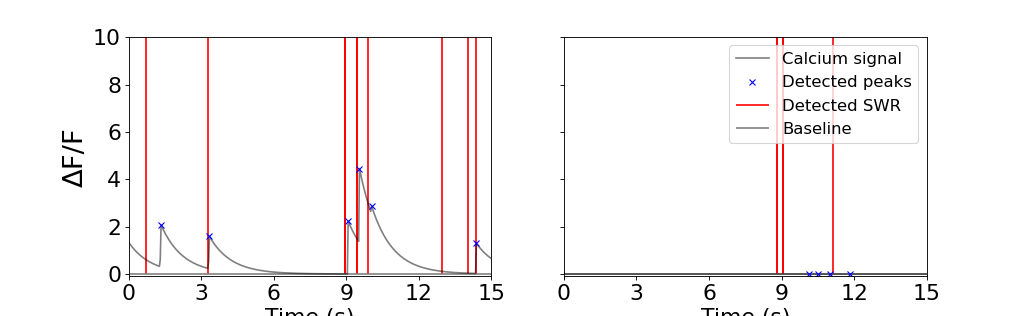

7.938179137386117e-09


In [107]:
fig, ax = plt.subplots(1,2, sharex=False, sharey=True, figsize=(13,4))

i=12
print(baseline_all_units[i])
ax[0].set_xlim(2100, 2115) 
ax[0].set_ylim(-0.1, 10)
ax[0].vlines(online_spon_responsive_all_units[i], 0, 10, 'r') 
ax[0].plot(x_spon,y_all_spon[i],'k',alpha=0.5)
ax[0].plot(peaks_spon_to_time[i], y_all_spon[i][peaks_spon_list[i]], "x",color='b')
ax[0].hlines(baseline_all_units[i], 1900, 2300, color="gray")
 

ax[1].set_xlim(2363, 2378)
ax[1].vlines(online_stim_responsive_all_units[i], 0, 10, 'r', alpha=1)
ax[1].plot(x_stim,y_all_stim[i],'k',alpha=0.5)
ax[1].plot(peaks_stim_to_time[i], y_all_stim[i][peaks_stim_list[i]], "x", color='b')
ax[1].hlines(baseline_all_units[i], 2350, 2470, color="gray")
ax[1].legend(['Calcium signal','Detected peaks','Detected SWR','Baseline'], fontsize=15)


x_ticks_labels=['0', '3','6', '9', '12', '15']
ax[0].set_xticks(np.linspace(2100,2115,6))
ax[1].set_xticks(np.linspace(2363,2378,6))
ax[0].set_xticklabels(x_ticks_labels, fontsize=20, rotation='horizontal')
ax[1].set_xticklabels(x_ticks_labels, fontsize=20, rotation='horizontal')
ax[0].set_xlabel('Time (s)',fontsize=20)
ax[1].set_xlabel('Time (s)',fontsize=20)

y_ticks_labels=['0', '2', '4', '6','8','10']
ax[0].set_yticklabels(y_ticks_labels, fontsize=20, rotation='horizontal')
ax[0].set_ylabel('ΔF/F',fontsize=25)
ax[0].set_yticks(np.linspace(0,10,6))

## 4-2. Compute SWR frequency

In [108]:
spon_time=round(x_spon[-1]-x_spon[0],0)
stim_time=round(x_stim[-1]-x_stim[0],0)

no_SWR_spon=len(online_spon)
no_SWR_stim=len(online_stim)

f_SWR_spon=round(len(online_spon)/spon_time,2)
f_SWR_stim=round(len(online_stim)/stim_time,2)

print(f_SWR_spon)
print(f_SWR_stim)


data=[(spon_time,stim_time,no_SWR_spon,no_SWR_stim,f_SWR_spon,f_SWR_stim)]

SWR_duration=pd.DataFrame(data,
                          columns=[["Recording duration (S)","Recording duration (S)", "No.of SWR","No.of SWR",
                          "SWR Frequency (Hz)","SWR Frequency (Hz)"],
                        ["spontaneous","Disrupted",'spontaneous','Disrupted',"spontaneous","Disrupted"]] 
                         ,index=['Animal 1'])

SWR_duration.to_csv('MD15_SWR_duration.csv')

0.93
0.84


## 4-3. Compare SWR vs nonSWR peaks

In [109]:
#define SWR-area vs Non SWR-area

x_spon_array=np.array(x_spon)
x_stim_array=np.array(x_stim)

#spontaneous condition
SWR_time_index_spon=[]
SWR_window_spon=[]
for ripple in online_spon: #for each SWR detection in spon
    SWR_window_spon =np.where(np.logical_and(x_spon_array>ripple, x_spon_array<ripple+2))[0] #2s window after detection
    SWR_time_index_spon.extend(SWR_window_spon)
 
SWR_time_index_spon=set(SWR_time_index_spon)
SWR_time_index_spon=list(SWR_time_index_spon)
SWR_time_spon=x_spon_array[SWR_time_index_spon]

non_SWR_time_spon=list(set(x_spon_array)-set(SWR_time_spon))
non_SWR_time_spon.sort()




#disrupted condition
SWR_time_index_stim=[]
SWR_window_stim=[]
for ripple in online_stim: #for each SWR detection in stim
    SWR_window_stim =np.where(np.logical_and(x_stim_array>ripple, x_stim_array<ripple+2))[0] #2s window after detection
    SWR_time_index_stim.extend(SWR_window_stim)
 
SWR_time_index_stim=set(SWR_time_index_stim)
SWR_time_index_stim=list(SWR_time_index_stim)
SWR_time_stim=x_stim_array[SWR_time_index_stim]

non_SWR_time_stim=list(set(x_stim_array)-set(SWR_time_stim))
non_SWR_time_stim.sort()


In [110]:
#compare average peak amplitude: SWR vs non-SWR

#spontaneous, SWR vs non_SWR
SWR_average_peak_spon_all_units=[]
non_SWR_average_peak_spon_all_units=[]

for i in range(len(Ca_corrected_frames_spon_clean)):
    SWR_peaks_spon=[]
    non_SWR_peaks_spon=[]

    for peak_number, peak_time in enumerate(peaks_spon_to_time[i]):
        if peak_time in SWR_time_spon:
            SWR_peaks_spon.append(peaks_property_spon.iloc[i]['Spontaneous']['peak amplitude'][peak_number])
        else:
            non_SWR_peaks_spon.append(peaks_property_spon.iloc[i]['Spontaneous']['peak amplitude'][peak_number])

    if len(SWR_peaks_spon)>0 and len(non_SWR_peaks_spon)>0:
        SWR_average_peak_spon_per_unit= sum(SWR_peaks_spon)/len(SWR_peaks_spon)
        non_SWR_average_peak_spon_per_unit= sum(non_SWR_peaks_spon)/len(non_SWR_peaks_spon)

    SWR_average_peak_spon_all_units.append(SWR_average_peak_spon_per_unit)
    non_SWR_average_peak_spon_all_units.append(non_SWR_average_peak_spon_per_unit)

#disrupted, SWR vs non_SWR
SWR_average_peak_stim_all_units=[]
non_SWR_average_peak_stim_all_units=[]

for i in range(len(Ca_corrected_frames_stim_clean)):
    SWR_peaks_stim=[]
    non_SWR_peaks_stim=[]

    for peak_number, peak_time in enumerate(peaks_stim_to_time[i]):
        if peak_time in SWR_time_stim:
            SWR_peaks_stim.append(peaks_property_stim.iloc[i]['Stim']['peak amplitude'][peak_number])
        else:
            non_SWR_peaks_stim.append(peaks_property_stim.iloc[i]['Stim']['peak amplitude'][peak_number])
            
    if len(SWR_peaks_stim)>0 and len(non_SWR_peaks_stim)>0 :
        SWR_average_peak_stim_per_unit= sum(SWR_peaks_stim)/len(SWR_peaks_stim)
        non_SWR_average_peak_stim_per_unit= sum(non_SWR_peaks_stim)/len(non_SWR_peaks_stim)

    SWR_average_peak_stim_all_units.append(SWR_average_peak_stim_per_unit)
    non_SWR_average_peak_stim_all_units.append(non_SWR_average_peak_stim_per_unit)

    
    
peaks_avg_amp_spon_SWR_nonSWR=pd.DataFrame({'SWR':SWR_average_peak_spon_all_units, 
                                             'nonSWR':non_SWR_average_peak_spon_all_units})
peaks_avg_amp_stim_SWR_nonSWR=pd.DataFrame({'SWR':SWR_average_peak_stim_all_units, 
                                             'nonSWR':non_SWR_average_peak_stim_all_units})

## 4-4. Save data to csv file

In [134]:
#Save peak properties

peaks_property_spon=pd.DataFrame(columns =[['unit','Spontaneous','Spontaneous'],
                             ['unit','peak time','peak amplitude']])
for i in range(len(Ca_corrected_frames_spon_clean)):
    peaks_property_spon.loc[i]=[i,peaks_spon_to_time[i], y_all_spon[i][peaks_spon_amp[i]]]
    
    
peaks_property_stim=pd.DataFrame(columns =[['unit','Stim','Stim'],
                             ['unit','peak time','peak amplitude']])
for i in range(len(Ca_corrected_frames_stim_clean)):
    peaks_property_stim.loc[i]=[i,peaks_stim_to_time[i], y_all_stim[i][peaks_stim_amp[i]]]



In [120]:
os.getcwd()
#os.chdir('path to your folder to store the file')
os.chdir('/home/chaeyoungkim/Desktop/Miniscope data/processed_dataframes/animals_summary')

peaks_property_spon.to_csv('MD15_spon.csv')
peaks_property_stim.to_csv('MD15_stim.csv')

peaks_avg_amp_spon_SWR_nonSWR.to_csv('MD15_avg_amp_spon_SWR_nonSWR.csv')
peaks_avg_amp_stim_SWR_nonSWR.to_csv('MD15_avg_amp_stim_SWR_nonSWR.csv')

peak_change_diff.to_csv('MD15_peak_change_diff.csv')
nonSWR_peak_change_diff.to_csv('MD15_nonSWR_peak_change_diff.csv')
 

# 5. Evaluate online SWR detection

## 5-1. Remove evoked response artefacts

[-148.39817369 -161.53343244 -136.61404558  -41.71912892 -139.795138  ]
[1766.846243, 1766.846493, 1766.846743, 1766.8469929999999, 1766.847243]


<IPython.core.display.Javascript object>


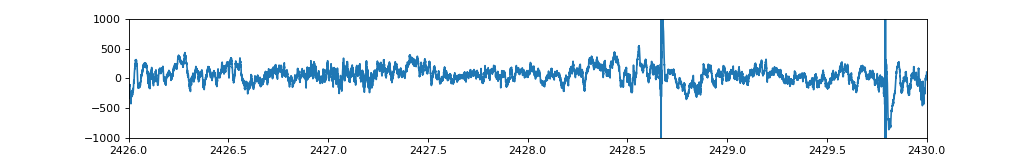

<IPython.core.display.Javascript object>


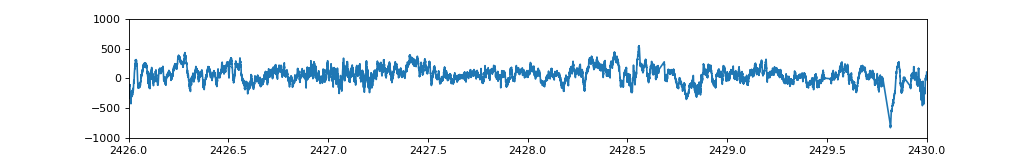

(-1000.0, 1000.0)

In [122]:
from fklab.signals.core.basic_algorithms import remove_artefacts

signal = downsampled[9]['signal']
signal = np.array(signal)
print(signal[0:5])

time = downsampled[9]['time']
time = time.tolist()
print(time[0:5])

pre_artefact  =  0.010
post_artefact =  0.017 
stim_times = np.array(stim_start)
stim_times = np.append(stim_times,[2424.35, 2429.5, 2429.8, 2429.9])

#add remving_artefacts on detection_times in the case of delayed stim
signal_wo_artefact = remove_artefacts( signal=signal, time=time, interp="linear", artefacts = stim_times, 
                                window= [-1*pre_artefact, post_artefact] )  

time_artefact=[2426, 2430]

plt.figure(figsize=(13,2))
plt.plot(downsampled[9]['time'], downsampled[9]['signal'])
plt.xlim(time_artefact[0],time_artefact[1])
plt.ylim(-1000, 1000)

plt.figure(figsize=(13,2))
plt.plot(downsampled[9]['time'], signal_wo_artefact)
plt.xlim(time_artefact[0],time_artefact[1])
plt.ylim(-1000, 1000)

## 5-2. Compute SWR envelope

In [124]:
smooth=0.015

SWR_envelope_spon = compute_envelope(
       apply_filter(downsampled[9]['signal'], 'ripple', fs=4000), isfiltered=True, freq_band='ripple',smooth_options=dict(bandwidth=smooth))

SWR_envelope_stim = compute_envelope(
       apply_filter(signal_wo_artefact, 'ripple', fs=4000),isfiltered=True, freq_band='ripple',smooth_options=dict(bandwidth=smooth))

<IPython.core.display.Javascript object>


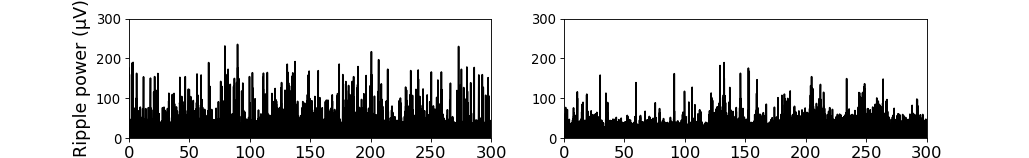

[Text(0, 0, '0'), Text(0, 0, '100'), Text(0, 0, '200'), Text(0, 0, '300')]

In [126]:
fig, ax = plt.subplots(1, 2, sharex=False,  figsize=(13,2))

x_ticks_labels = [ '0','50','100','150','200','250','300']
y_ticks_labels = [ '0','100','200','300'] 

ax[0].plot(downsampled[9]['time'],SWR_envelope_spon, 'k')
ax[0].set_xlim(1900, 2200)
ax[0].set_ylim(0, 250)
ax[0].set_ylabel('Ripple power (µV)',  fontsize=16)
ax[0].set_xlabel('Time (s)', fontsize = 15)

 
ax[1].plot(downsampled[9]['time'],SWR_envelope_stim , 'k')
ax[1].set_xlim(2400, 2700)
ax[1].set_ylim(0, 250)
ax[1].set_xlabel('Time (s)', fontsize = 15)

 
ax[0].set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=15)
ax[1].set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=15)
ax[0].set_yticks(np.linspace(0,300,4))
ax[1].set_yticks(np.linspace(0,300,4))
ax[0].set_yticklabels(y_ticks_labels, rotation='horizontal', fontsize=12)
ax[1].set_yticklabels(y_ticks_labels, rotation='horizontal', fontsize=12)

## 5-3. Plot Online SWRs

In [127]:
SWR_envelope_spon_average_online,lag_SWR_online=event_triggered_average(online_spon,downsampled[9]['time'],SWR_envelope_spon)

SWR_envelope_stim_average_online,lag_SWR_online_stim=event_triggered_average(online_stim,downsampled[9]['time'],SWR_envelope_stim) 

<IPython.core.display.Javascript object>


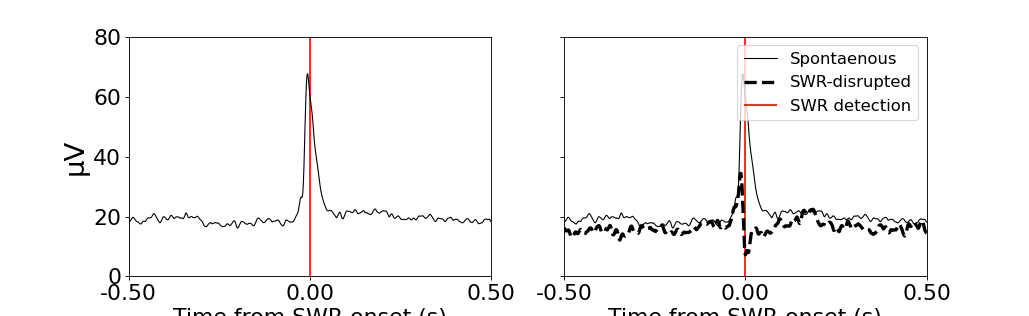

In [131]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(13,4))

ax[0].plot(lag_SWR_online, SWR_envelope_spon_average_online,  'k', lw='1')
ax[0].vlines(0,0, 80, 'r', label='_nolegend_')

ax[0].set_xlabel('Time from SWR onset (s)', fontsize=20)
ax[0].set_ylabel('μV', fontsize=25)
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylim(0, 80)

x_ticks_labels=['-0.50','0.00','0.50']    
ax[0].set_xticks(np.linspace(-0.5,0.5,3))
ax[0].set_xticklabels(x_ticks_labels, fontsize=20)

y_ticks_labels=['0','20','40','60','80']
ax[0].set_yticks(np.linspace(0,80,5))
ax[0].set_yticklabels(y_ticks_labels, fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)


ax[1].plot(lag_SWR_online,      SWR_envelope_spon_average_online,  'k', lw='1')
ax[1].plot(lag_SWR_online_stim, SWR_envelope_stim_average_online,  'k', lw='3', linestyle='dashed')
ax[1].vlines(0,0, 80, 'r', label='SWR detection')
 
ax[1].set_xlabel('Time from SWR onset (s)', fontsize=20)
ax[1].set_xlim(-0.5, 0.5)
ax[1].set_ylim(0, 80)

ax[1].set_xticks(np.linspace(-0.5,0.5,3))
ax[1].set_xticklabels(x_ticks_labels, fontsize=20)

ax[1].set_yticks(np.linspace(0,80,5))
ax[1].set_yticklabels(y_ticks_labels, fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

ax[1].legend(["Spontaenous", "SWR-disrupted",'SWR detection'], loc ="upper right", fontsize=15) 